**Load data**

In [1]:
# -*- coding: utf-8 -*-

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

df = pd.read_csv("trainingsdaten_ohne_vibration.csv")
del df["Time"]
df_test = pd.read_csv("testdaten_mit_vibration.csv")
del df_test["Time"]

**Descriptive statistics**

In [2]:
df.describe()

,AmplitudeBandWidth,AmplitudeMean,NumberOverload,NumberUnderloads,StabilizationTime
count,2090.000000,2090.000000,2090.0,2090.0,2090.000000
mean,1.159642,0.519354,0.0,0.0,4130.505742
std,1.760196,0.676685,0.0,0.0,773.941131
min,0.000000,0.000000,0.0,0.0,3011.000000
25%,0.320000,0.168000,0.0,0.0,3245.000000
50%,0.471000,0.254000,0.0,0.0,4462.000000
75%,0.830250,0.416000,0.0,0.0,4837.000000
max,18.418000,7.834000,0.0,0.0,6927.000000


In [3]:
df_test.describe()

,AmplitudeBandWidth,AmplitudeMean,NumberOverload,NumberUnderloads,StabilizationTime
count,187.000000,187.000000,187.0,187.0,187.000000
mean,70.186679,32.865059,0.0,0.0,4148.048128
std,123.702463,87.268628,0.0,0.0,1364.414429
min,0.061000,0.042000,0.0,0.0,2481.000000
25%,29.116000,9.063000,0.0,0.0,3050.500000
50%,38.549000,12.502000,0.0,0.0,3760.000000
75%,51.010500,17.995000,0.0,0.0,4704.000000
max,580.684000,496.094000,0.0,0.0,8815.000000


**Visualize data**

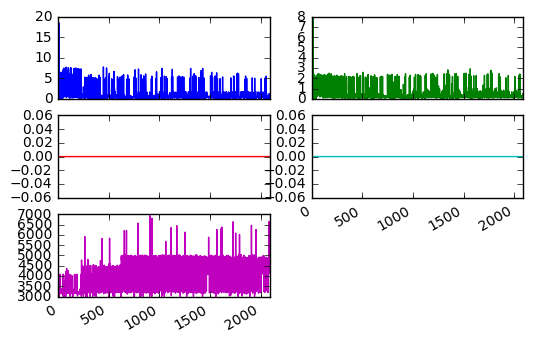

In [4]:
df.plot(subplots=True, layout=(3,2), legend=False)
plt.show()

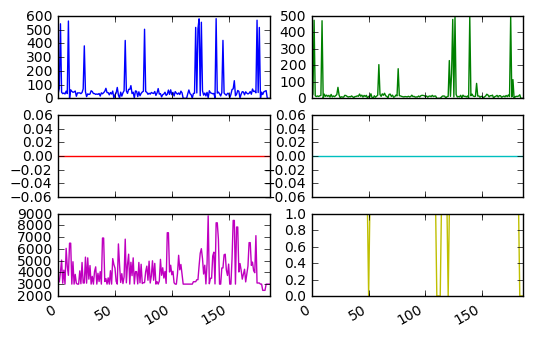

In [5]:
df_test.plot(subplots=True, layout=(3,2), legend=False)
plt.show()

**Data cleaning**

In [6]:
#Descriptive statistics & visualization show that 2 columns do not contain any information, so drop them
df = df.drop(['NumberOverload', 'NumberUnderloads'], 1)
df_test = df_test.drop(['NumberOverload', 'NumberUnderloads'], 1)

**Define test and training data**

In [7]:
X_train = df
X_test = df_test[['AmplitudeBandWidth', 'AmplitudeMean', 'StabilizationTime']].copy()
y_test = df_test[['VibrationMotorOn']].copy()

**Train model**

In [8]:
#Model fitting
clf = IsolationForest()
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size

print("n_error_train:", n_error_train)
print("n_error_test:", n_error_test)

new_column = pd.DataFrame(columns = ["Anomaly"])
for k in range(len(X_test)):
    temp = clf.predict([[X_test["AmplitudeBandWidth"][k], X_test["AmplitudeMean"][k], X_test["StabilizationTime"][k]]])[0]
    new_column = new_column.append({"Anomaly": temp}, ignore_index = True)

#recode prediction to fit true/false
new_column['Anomaly'] = new_column['Anomaly'].map( {1: 0, -1: 1} )

('n_error_train:', 209)
('n_error_test:', 178)


**Metrics**

In [9]:
from sklearn import metrics

print("accuracy: ", metrics.accuracy_score(y_test, new_column))  
print("precision: ", metrics.precision_score(y_test, new_column))  
print("recall: ", metrics.recall_score(y_test, new_column))  
print("f1: ", metrics.f1_score(y_test, new_column))  
print("confusion matrix:")
print(metrics.confusion_matrix(y_test, new_column))  

('accuracy: ', 0.96256684491978606)
('precision: ', 0.97752808988764039)
('recall: ', 0.98305084745762716)
('f1: ', 0.9802816901408451)
confusion matrix:
[[  6   4]
 [  3 174]]


**Visualize first detected anomalies, then ground truth**

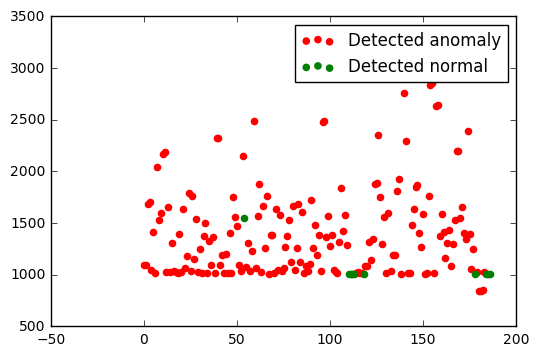

In [10]:
complete_data = X_test.copy()
complete_data['VibrationMotorOn'] = y_test['VibrationMotorOn']
complete_data['Anomaly'] = new_column.values

from matplotlib import pyplot as plt

fig, ax = plt.subplots()
a = complete_data[['AmplitudeBandWidth', 'AmplitudeMean', 'StabilizationTime']].loc[complete_data['Anomaly'] == 1] #detected anomaly
n = complete_data[['AmplitudeBandWidth', 'AmplitudeMean', 'StabilizationTime']].loc[complete_data['Anomaly'] == 0] #detected normal

ax.scatter(a.index,a.mean(axis=1), color='red', label='Detected anomaly')
ax.scatter(n.index,n.mean(axis=1), color='green', label='Detected normal')

plt.legend()
plt.show()

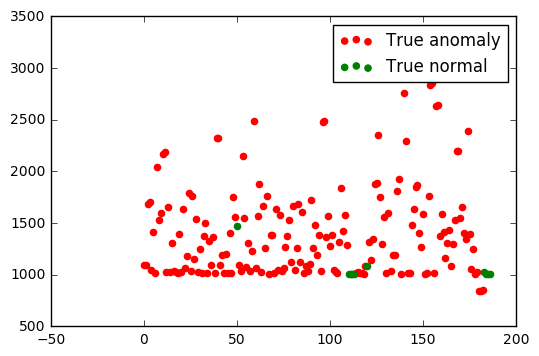

In [11]:
fig, ax = plt.subplots()
a = complete_data[['AmplitudeBandWidth', 'AmplitudeMean', 'StabilizationTime']].loc[complete_data['VibrationMotorOn'] == 1] #true anomaly
n = complete_data[['AmplitudeBandWidth', 'AmplitudeMean', 'StabilizationTime']].loc[complete_data['VibrationMotorOn'] == 0] #true normal

ax.scatter(a.index,a.mean(axis=1), color='red', label='True anomaly')
ax.scatter(n.index,n.mean(axis=1), color='green', label='True normal')

plt.legend()
plt.show()